In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, TimeDistributed
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import sqrt

In [3]:
np.random.seed(7)
tf.random.set_seed(7)

In [5]:
csv_path = "train.csv"
train = pd.read_csv(csv_path, parse_dates=['date'])

# Filtro una serie
train = train.query("store == 1 and item == 1").copy()
train = train.sort_values("date")
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
1821,2017-12-27,1,1,14
1822,2017-12-28,1,1,19
1823,2017-12-29,1,1,15
1824,2017-12-30,1,1,27


In [6]:
def make_supervised_windows(series: np.ndarray, window: int, lag: int):
  X, y = [], []
  for i in range(window, len(series) - lag):
    X += [series[i-window:i+1]]
    y += [series[i+lag]]
  return np.array(X), np.array(y)

In [7]:
window = 29
lag = 1
X, y = make_supervised_windows(train["sales"].values, window, lag)
print("X:", X.shape, "y:", y.shape)

X: (1796, 30) y: (1796,)


In [8]:
# División temporal y escalado
cut = int(len(X) * 0.8)
X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

# Escalado
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))

X_train_scaled = scaler_x.transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

print("X train scaled:", X_train_scaled.shape, " y train scaled:", y_train_scaled.shape)
print("X test scaled:", X_test_scaled.shape, " y test scaled:", y_test_scaled.shape)

X_train_3d = X_train_scaled.reshape((len(X_train_scaled), window+1, 1))
X_test_3d = X_test_scaled.reshape((len(X_test_scaled), window+1, 1))

print("Train 3D:", X_train_3d.shape, y_train_scaled.shape)
print("Test 3D:", X_test_3d.shape, y_test_scaled.shape)

X train scaled: (1436, 30)  y train scaled: (1436,)
X test scaled: (360, 30)  y test scaled: (360,)
Train 3D: (1436, 30, 1) (1436,)
Test 3D: (360, 30, 1) (360,)


In [9]:
# CNN 1D
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window+1, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(1)
])

model_cnn.compile(optimizer="adam", loss="mse")
model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        14,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,529 (56.75 KB)

 Trainable params: 14,529 (56.75 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history_cnn = model_cnn.fit(X_train_3d, y_train_scaled, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7024
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5307
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5068
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4923
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4800
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4692
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4585
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4504
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4418
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4337
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4242
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4165
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4096
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4021
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3950
Epoch 16/50
45/45 ━

In [11]:
# predictions
pred_cnn_s = model_cnn.predict(X_test_3d).ravel()
pred_cnn = scaler_y.inverse_transform(pred_cnn_s.reshape(-1,1)).ravel()
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred_cnn)):.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 6.5767


In [12]:
# LSTM
model_lstm = Sequential([
    LSTM(32, activation="tanh", input_shape=(window+1,1)),
    Dense(1)
])
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history_lstm = model_lstm.fit(X_train_3d, y_train_scaled, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.7011
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6136
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6112
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6092
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6075
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6061
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6049
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6038
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6028
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6018
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6009
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6001
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5992
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5984
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5977
Epoc

In [15]:
pred_lstm_s = model_lstm.predict(X_test_3d).ravel()
pred_lstm = scaler_y.inverse_transform(pred_lstm_s.reshape(-1,1)).ravel()
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred_lstm)):.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 5.3167


In [17]:
# CNN + LSTM
subseq = 5
assert (window+1) % subseq == 0, "window must be divisible by subseq"
steps_per_subseq = (window+1) // subseq

Xtr4 = X_train_3d.reshape((len(X_train_3d), subseq, steps_per_subseq, 1))
Xva4 = X_test_3d.reshape((len(X_test_3d), subseq, steps_per_subseq, 1))

model_cnn_lstm = Sequential([
    TimeDistributed(Conv1D(filters=32, kernel_size=3, activation="relu"),
                    input_shape=(subseq, steps_per_subseq, 1)),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(32, activation="tanh"),
    Dense(1)
])
model_cnn_lstm.compile(optimizer="adam", loss="mse")
model_cnn_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 5, 4, 32)       │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 2, 32)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 64)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,577 (49.13 KB)

 Trainable params: 12,577 (49.13 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_cnn_lstm = model_cnn_lstm.fit(Xtr4,
                                      y_train_scaled,
                                      epochs=50,
                                      batch_size=32,
                                      verbose=1)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.8374
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6043
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5826
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5684
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5599
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5519
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5443
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5375
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5317
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5265
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5219
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5179
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5143
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5108
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5074
Epoch 16/50
45/

In [20]:
# Xva4 are the test samples
pred_cnn_lstm_s = model_cnn_lstm.predict(Xva4).ravel()
pred_cnn_lstm = scaler_y.inverse_transform(pred_cnn_lstm_s.reshape(-1,1)).ravel()
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred_cnn_lstm)):.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
RMSE: 5.4562


In [22]:
# Plotting results
rmse_cnn = np.sqrt(mean_squared_error(y_test, pred_cnn))
rmse_lstm = np.sqrt(mean_squared_error(y_test, pred_lstm))
rmse_cnn_lstm = np.sqrt(mean_squared_error(y_test, pred_cnn_lstm))

print("Summary RMSE\n")
print(f"CNN: {rmse_cnn:.4f}")
print(f"LSTM: {rmse_lstm:.4f}")
print(f"CNN + LSTM: {rmse_cnn_lstm:.4f}")

Summary RMSE

CNN: 6.5767
LSTM: 5.3167
CNN + LSTM: 5.4562


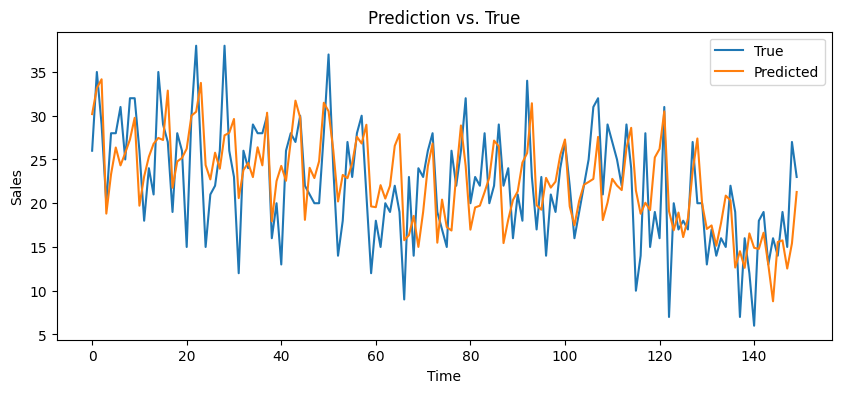

In [25]:
y_true = y_test
y_pred = pred_cnn_lstm

k = 150 if len(y_true) > 150 else len(y_true)

plt.figure(figsize=(10,4))
plt.plot(y_true[-k:], label="True")
plt.plot(y_pred[-k:], label="Predicted")
plt.title("Prediction vs. True")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()